## Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns

## Fit Linear Regression to the Data Set

In this section, we will use the given price and demand data to create a simple linear regression model to predict demand based on price, using price as the sole x variable. 

In [3]:
# Load the data
data = pd.read_csv('price_demand_data.csv')

# Extract price and demand
prices = data['price'].values.reshape(-1, 1)
demands = data['demand'].values

# Linear regression
reg = LinearRegression().fit(prices, demands) #fit linear regression model 

#save coefficients and intercept
beta0 = reg.intercept_
beta1 = reg.coef_[0]

#print coefficient and intercept
print(f"Regression results: beta0 = {beta0:.2f}, beta1 = {beta1:.2f}")

Regression results: beta0 = 1924.72, beta1 = -1367.71


## Calculate the Residuals and Generate Demand Data for p = $1

In this section, we will keep price static at 1 dollar and generate new demand data based on this. In future sections, we'll introduce the effect of price on demand by allowing price to change in the optimization model. For now, in this section and the following one, we will optimize the newspaper production quantity based on a static price.  
To start, we will calculate a new set of demand data based on the residuals (true demand - predicted demand) from the linear regression model. We will then use these residuals to predict demand using price = $1. 

In [3]:
# Calculate residuals from the linear regression in the previous step
predicted_demands = reg.predict(prices)
residuals = demands - predicted_demands

# Fixed price
p_fixed = 1.0

# Generate demand data using residuals at p = $1
demand_p_fixed = beta0 + beta1 * p_fixed + residuals

# Ensure that demands are non-negative
demand_p_fixed = np.maximum(demand_p_fixed, 0)

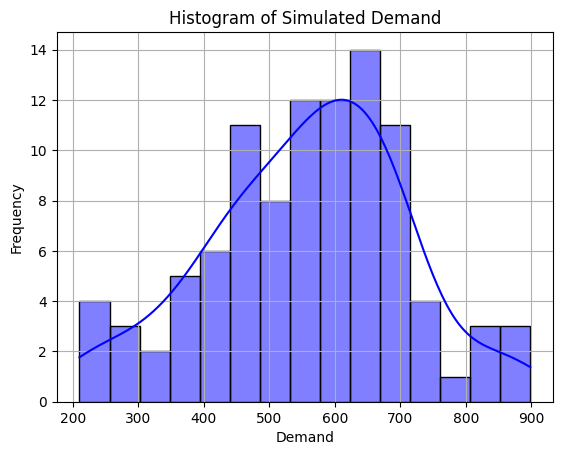

In [13]:
#histogram displaying the distribution of the generated demand values from the previous code block
sns.histplot(demand_p_fixed, bins=15, kde=True, color='blue')
plt.title("Histogram of Simulated Demand")
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The above histogram shows the distribution of demand values generated from the linear regression model and residuals. As we can see, demand has a peak between 600-700 and ranges from roughly 200 to 900. 

## Solve Linear Program for Quantity When p = $1

Here, we've created a linear program to understand the optimal quantity of newspapers to produce or purchase when the price remains static, at $1. 
We've chosen to keep the variable type for quantity continuous here, assuming that the quantity is in units of pallets or boxes of newspapers. Therefore, decimal quantities of optimal production amounts make sense here, as they can represent partial pallets or boxes. 

In [4]:
# Production cost
c = 0.5
# Rushed newspaper cost   
g = 0.75
# Disposal cost 
t = 0.15  

#set variable for number of demand values
n = len(demand_p_fixed)
D = demand_p_fixed

# Initialize model
fixed_price_lp = gp.Model()

# Quantity to produce
q = fixed_price_lp.addVar(lb=0, vtype=GRB.CONTINUOUS)

# Dummy variables: h_i for each demand instance -- represent the profit in scenario i -- linearizes the problem
h = fixed_price_lp.addVars(n, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS)

# Set objective: maximize average profit
fixed_price_lp.setObjective((1/n) * gp.quicksum(h[i] for i in range(n)), GRB.MAXIMIZE)

# Add constraints with surplus and shortage variables
for i in range(n):
    surplus = fixed_price_lp.addVar(lb=0, vtype=GRB.CONTINUOUS) #create a variable for the surplus (amt produced over demand)
    shortage = fixed_price_lp.addVar(lb=0, vtype=GRB.CONTINUOUS) #create a variable for the shortage (amt of demand over the day's inventory) 
    #surplus units for current scenario -- surplus units is at least = surplus quantity
    #if q > D_i, surplus = q - D_i, else (D_i >= q) surplus units = 0
    fixed_price_lp.addConstr(surplus >= q - D[i])
    #shortage units for current scenario -- surplus units is at least = shortage quantity
    #if D_i > q, shortage = D_i - q, else (q >= D_i) shortage units = 0
    fixed_price_lp.addConstr(shortage >= D[i] - q)
    #constraint to calculate the profit for current scenario
    #profit <= Revenue - Total Costs
    #h_i <= (price * D_i) - (c * q + g * shortage + t * surplus)
    fixed_price_lp.addConstr(h[i] <= p_fixed * D[i] - c * q - g * shortage - t * surplus)

# Optimize
fixed_price_lp.Params.OutputFlag = 0 
fixed_price_lp.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-24


#### Optimal Quantity When p = $1

Below, we can see that assuming price remains static at 1 dollar, the optimal production quantity of newspaper pallets is 471.87, and the profit we will achieve is $231.48.

In [5]:
# Get optimal quantity
q_optimal_fixed_price = q.X
q_optimal_profit = fixed_price_lp.objVal

print(f"Optimal quantity when p = ${p_fixed}: q = {q_optimal_fixed_price:.2f}")
print(f"Optimal profit when p = ${p_fixed}: profit = {q_optimal_profit:.2f}")

Optimal quantity when p = $1.0: q = 471.87
Optimal profit when p = $1.0: profit = 231.48


## Letting Price Impact Demand Using Quadratic Programming

It's unrealistic to assume that demand will respond the same way to every single possible price. Therefore, in this section, we will allow price to impact demand by allowing the value to vary. We will do this using quadratic programming in Gurobi. 

In [6]:
# Initialize model
variable_price_qp = gp.Model()

# q (quantity to produce) 
q_qp = variable_price_qp.addVar(lb=0, vtype=GRB.CONTINUOUS)
# p (price)
p_qp = variable_price_qp.addVar(lb=0, vtype=GRB.CONTINUOUS)

# dummy variables: h_i for each demand instance -- profit for each instance
h_qp = variable_price_qp.addVars(n, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS)

# maximize average profit over all demand scenarios
variable_price_qp.setObjective((1/n) * gp.quicksum(h_qp[i] for i in range(n)), GRB.MAXIMIZE)

# Add constraints
for i in range(n):
    # D_i as function of p (price)
    D_i = variable_price_qp.addVar(lb=0, vtype=GRB.CONTINUOUS)
    # demand = the demand calculated from the regression model
    variable_price_qp.addConstr(D_i == beta0 + beta1 * p_qp + residuals[i])

    # Surplus and shortage variables
    surplus = variable_price_qp.addVar(lb=0, vtype=GRB.CONTINUOUS)
    shortage = variable_price_qp.addVar(lb=0, vtype=GRB.CONTINUOUS)
    # surplus is at least quantity - demand (when prod > demand)
    variable_price_qp.addConstr(surplus >= q_qp - D_i)
    # shortage is at least demand - quantity (when demand > prod)
    variable_price_qp.addConstr(shortage >= D_i - q_qp)

    # Revenue = price (p) * demand (D_i)
    revenue = p_qp * D_i
    # Cost = prod cost (c * q_qp) + rushed newspaper cost (g * shortage) + disposal cost (t * surplus)
    cost = c * q_qp + g * shortage + t * surplus

    # Profit h_i = h_i <= revenue - cost
    variable_price_qp.addConstr(h_qp[i] <= revenue - cost)

# Optimize
variable_price_qp.Params.OutputFlag = 0 
variable_price_qp.optimize()

#### Optimal Quantity and Price When Price Impacts Demand Using Quadratic Programming
Below, we can see the outputs of the quadratic programming model. This shows that the optimal quantity of newspaper pallets to produce is 535.29, which will produce an optimal (highest) profit value of $234.42. We also have an additional decision variable introduced here: price. If we allow price to impact demand, then the aforementioned profit value can be generated using an optimal price of 0.95. 

In [7]:
# optimal price 
p_optimal = p_qp.X
# optimal quantity
q_optimal = q_qp.X
#optimal profit
profit_optimal = variable_price_qp.objVal

print(f"Optimal price: p = ${p_optimal:.2f}")
print(f"Optimal quantity: q = {q_optimal:.2f}")
print(f"Optimal profit: q = {profit_optimal:.2f}")

Optimal price: p = $0.95
Optimal quantity: q = 535.29
Optimal profit: q = 234.42


## Bootstrap Sensitivity Analysis

In the final phase of the analysis, we will repeatedly bootstrap (sample) the data and run quadratic programming models to generate a distribution of optimal prices, production quantities, and profits. This will allow us to see if the decision variables' optimal values cluster around a particular range, and help reduce the impact of variability in the data set. In other words, some samples will contain data on an extreme end of the spectrum, and doing repeated boostrapping will allow us to ensure we are getting an unbiased, "averaged" look at the data. 
We will use 1000 bootstrapping iterations. 

In [8]:
# Number of bootstrap samples
num_bootstrap = 1000

# Lists to store bootstrap results
optimal_prices = []
optimal_quantities = []
expected_profits = []

In [9]:
for b in range(num_bootstrap):
    # Resample data with replacement
    bootstrap_data = data.sample(n=len(data), replace=True)
    prices_bootstrap = bootstrap_data['price'].values.reshape(-1, 1)
    demands_bootstrap = bootstrap_data['demand'].values

    # Refit regression model
    reg_bootstrap = LinearRegression().fit(prices_bootstrap, demands_bootstrap)
    beta0_bootstrap = reg_bootstrap.intercept_
    beta1_bootstrap = reg_bootstrap.coef_[0]

    # Residuals
    residuals_bootstrap = demands_bootstrap - reg_bootstrap.predict(prices_bootstrap)

    # Initialize model
    variable_price_qp_bootstrap = gp.Model()

    # Decision variables
    q_bootstrap = variable_price_qp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS)
    p_bootstrap = variable_price_qp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS)

    # Dummy variables
    h_bootstrap = variable_price_qp_bootstrap.addVars(n, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # Objective
    variable_price_qp_bootstrap.setObjective((1/n) * gp.quicksum(h_bootstrap[i] for i in range(n)), GRB.MAXIMIZE)

    # Constraints
    for i in range(n):
        # D_i as function of p
        residual_i = residuals_bootstrap[i]
        D_i = beta0_bootstrap + beta1_bootstrap * p_bootstrap + residual_i
        D_i_var = variable_price_qp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"D_{i}")
        variable_price_qp_bootstrap.addConstr(D_i_var == D_i)

        # Surplus and shortage
        surplus = variable_price_qp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"surplus_{i}")
        shortage = variable_price_qp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"shortage_{i}")
        variable_price_qp_bootstrap.addConstr(surplus >= q_bootstrap - D_i_var)
        variable_price_qp_bootstrap.addConstr(shortage >= D_i_var - q_bootstrap)

        # Revenue and cost
        revenue = p_bootstrap * D_i_var
        cost = c * q_bootstrap + g * shortage + t * surplus

        # Profit h_i
        variable_price_qp_bootstrap.addConstr(h_bootstrap[i] <= revenue - cost)

    # Optimize
    variable_price_qp_bootstrap.Params.OutputFlag = 0 
    variable_price_qp_bootstrap.optimize()

    # Store results
    optimal_prices.append(p_bootstrap.X)
    optimal_quantities.append(q_bootstrap.X)

    # Calculate expected profit
    profit = variable_price_qp_bootstrap.objVal
    expected_profits.append(profit)

In [10]:
optimal_p_bootstrap = p_bootstrap.X
optimal_q_bootstrap = q_bootstrap.X
optimal_profit_bootstrap = variable_price_qp_bootstrap.objVal

print(f"Optimal price from bootstrap sample: {optimal_p_bootstrap}")
print(f"Optimal quantity to produce from bootstrap sample: {optimal_q_bootstrap}")
print(f"Optimal profit from bootstrap sample: {optimal_profit_bootstrap}")

Optimal price from bootstrap sample: 0.9542189298382162
Optimal quantity to produce from bootstrap sample: 535.6085890263898
Optimal profit from bootstrap sample: 238.55354961482914


In [11]:
# Convert results to arrays for analysis
optimal_prices = np.array(optimal_prices)
optimal_quantities = np.array(optimal_quantities)
expected_profits = np.array(expected_profits)

## Visualizing the Data: Distribution of Optimal Prices, Quantities, and Profits
Finally, we will display our results in a series of plots to show the distributions of price, quantity produced, and profit values. 
As we can see from the plots: 
* the majority of optimal price values are clustered around just below 0.96;
* the majority of optimal quantity values are just under 525;
* expected profit is generally around $235;
* since we have done 1000 bootstrapping iterations, the distributions are beginning to take on the shape of a normal distribution. 

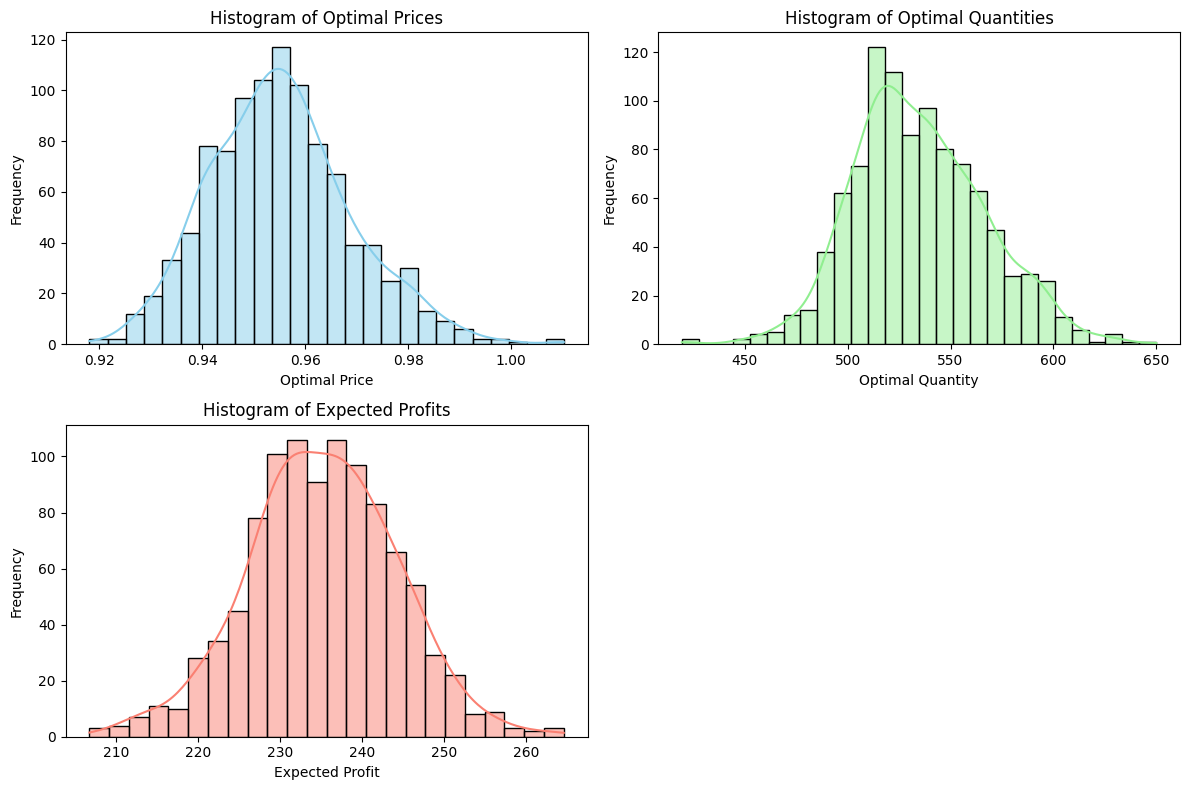

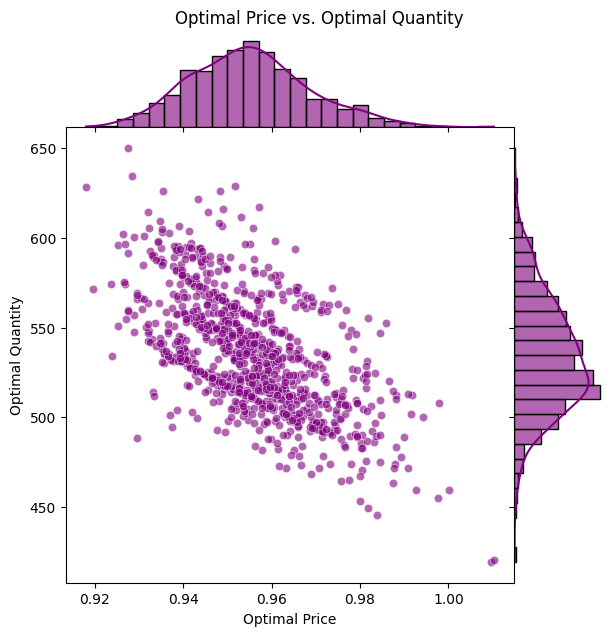

In [12]:
# Histograms of optimal prices and quantities
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(optimal_prices, kde=True, color='skyblue')
plt.title('Histogram of Optimal Prices')
plt.xlabel('Optimal Price')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(optimal_quantities, kde=True, color='lightgreen')
plt.title('Histogram of Optimal Quantities')
plt.xlabel('Optimal Quantity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(expected_profits, kde=True, color='salmon')
plt.title('Histogram of Expected Profits')
plt.xlabel('Expected Profit')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatterplot with histograms on the axes
# Use JointGrid from seaborn
g = sns.JointGrid(x=optimal_prices, y=optimal_quantities, space=0)
g.plot_joint(sns.scatterplot, color='purple', alpha=0.6)
g.plot_marginals(sns.histplot, kde=True, color='purple', alpha=0.6)
g.set_axis_labels('Optimal Price', 'Optimal Quantity')
plt.suptitle('Optimal Price vs. Optimal Quantity', y=1.02)
plt.show()